## Simulate some reflected light planets

In [1]:
%load_ext autoreload
%autoreload 2
from psisim import telescope,instrument,observation,spectrum,universe,plots
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline
import copy
import time
from astropy.io import fits
import astropy.units as u

Tried importing picaso, but couldn't do it


### Set up the telescope and instrument configuration

In [2]:
gemini = telescope.GeminiSouth()
gpi = instrument.GPI()
wvs,dwvs = gpi.get_effective_wavelength('H')
R = wvs/dwvs
gpi.set_observing_mode(60,38,'H',R,wvs,dwvs)

### Generate planets and host stars with EXOSIMS

We will make some cuts to limit to realistically detected planets.

The planet table has all the planet and host star properties, which we will use going forward

In [3]:
exosims_config_filename = "forBruceandDimitri_EXOCAT1.json" #Some filename here
uni = universe.ExoSims_Universe(exosims_config_filename)
uni.simulate_EXOSIMS_Universe()

planet_table = uni.planets
full_planet_table = copy.deepcopy(uni.planets)
#Down select the planets whose separations are less than lambda/D

##This step expects wvs in
min_iwa = np.min(gpi.current_wvs)*1e-6/gemini.diameter*206265
planet_table = planet_table[planet_table['AngSep'].to(u.arcsec).value > min_iwa]
planet_table = planet_table[planet_table['Flux Ratio'] > 1e-10] # this is a rough planet contrast estimated by EXOSIMS
n_planets = len(planet_table)

Imported TargetList (prototype module) from EXOSIMS.Prototypes.TargetList
Imported EXOCAT1 (specific module) from EXOSIMS.StarCatalog.EXOCAT1
Imported Nemati (specific module) from EXOSIMS.OpticalSystem.Nemati
Imported Stark (specific module) from EXOSIMS.ZodiacalLight.Stark
Imported PostProcessing (prototype module) from EXOSIMS.Prototypes.PostProcessing
Imported BackgroundSources (prototype module) from EXOSIMS.Prototypes.BackgroundSources
Imported Completeness (prototype module) from EXOSIMS.Prototypes.Completeness
Imported SAG13 (specific module) from EXOSIMS.PlanetPopulation.SAG13
Imported Forecaster (specific module) from EXOSIMS.PlanetPhysicalModel.Forecaster
Calculating target stellar masses.


In [4]:
planet_table

StarName,RA,Dec,Distance,Flux Ratio,AngSep,ProjAU,Phase,SMA,Ecc,Inc,PlanetMass,PlanetRadius,PlanetLogg,StarSpT,StarMass,StarTeff,StarRad,StarLogg,StarBMag,StarVmag,StarRmag,StarImag,StarJmag,StarHmag,StarKmag
,,,,,mas,AU,rad,AU,,deg,earthMass,earthRad,dex(cm / s2),,solMass,K,solRad,dex(cm / s2),,,,,,,
str12,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str14,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
HIP 57,0.16828599572181702,-69.6758041381836,29.87,1.2305761798026393e-07,4.098311764756113,0.15064648792925456,0.948613478001788,0.11014709344808045,0.5189181948906424,70.31961361751192,11.608729681501044,2.6967575475435632,3.1942559746075863,K2V,0.9491653815799038,5050.64469616304,0.8192143935707238,4.588614368860404,9.120000000000001,8.24,0.0,0.0,6.773,6.341,6.23
HIP 263,0.8292379975318909,4.687136173248291,29.21,8.347144532936679e-10,25.75804063605507,0.8118345643203013,1.9558443239922725,0.8438785654146584,0.08570960540884834,34.469747141197075,12.190986153182173,2.6795559801959903,3.2210682507899686,M1,0.5045692274242577,3839.195017835037,0.24093905210837854,5.377173992765379,13.51,12.04,0.0,0.0,8.833,8.183,7.9799999999999995
HIP 263,0.8292379975318909,4.687136173248291,29.21,1.2156149762472459e-10,136.75483600604082,4.502872541931168,1.091077106560874,3.3488893379673925,0.4061162193383995,96.50435328014949,4.603468307837776,1.8239971269558113,3.132191939757574,M1,0.5045692274242577,3839.195017835037,0.24093905210837854,5.377173992765379,13.51,12.04,0.0,0.0,8.833,8.183,7.9799999999999995
HIP 263,0.8292379975318909,4.687136173248291,29.21,1.0626881953888632e-10,81.5566298721096,6.7201472471521155,0.3623756190025811,8.466245564927327,0.2127037390110487,87.91258124991127,65.46584633520808,3.886922507716857,3.6279581040562587,M1,0.5045692274242577,3839.195017835037,0.24093905210837854,5.377173992765379,13.51,12.04,0.0,0.0,8.833,8.183,7.9799999999999995
HIP 263,0.8292379975318909,4.687136173248291,29.21,1.2226542275643859e-09,9.90465619487413,0.34661125019709305,2.1540122003541264,0.3276087466873865,0.08461075949420604,143.74855673192832,4.125183872534621,2.3317055751050444,2.871250970952797,M1,0.5045692274242577,3839.195017835037,0.24093905210837854,5.377173992765379,13.51,12.04,0.0,0.0,8.833,8.183,7.9799999999999995
HIP 263,0.8292379975318909,4.687136173248291,29.21,5.7325776778035484e-08,2.466698719947956,0.14270758648071127,0.5292596906231394,0.1232218983264864,0.2103599494567942,68.44507996368414,2.451509086757371,2.032054385000131,2.7647179352370683,M1,0.5045692274242577,3839.195017835037,0.24093905210837854,5.377173992765379,13.51,12.04,0.0,0.0,8.833,8.183,7.9799999999999995
HIP 263,0.8292379975318909,4.687136173248291,29.21,3.3609744561101914e-10,24.618140454342225,0.7209386700862088,1.6423111398399362,0.9189259380442404,0.2611908539272478,106.11519482925787,2.1599753281765173,1.1055578979912675,3.238440889545732,M1,0.5045692274242577,3839.195017835037,0.24093905210837854,5.377173992765379,13.51,12.04,0.0,0.0,8.833,8.183,7.9799999999999995
HIP 263,0.8292379975318909,4.687136173248291,29.21,1.8098674915161994e-09,14.943253794228818,0.5982646037333126,0.8177334149789507,0.5089694182024243,0.4526799052328969,118.40778098874284,7.380362399037381,1.5794587954694788,3.462216168290443,M1,0.5045692274242577,3839.195017835037,0.24093905210837854,5.377173992765379,13.51,12.04,0.0,0.0,8.833,8.183,7.9799999999999995


### We'll pick random planets, since many systems are multi-planet systems and they show up  sequentially in EXOSIMS

This example will only generate 2 planets for speed

In [4]:
planet_types = []
planet_spectra = []

n_planets_now = 2 # how many 

rand_planets = np.random.randint(0, n_planets, n_planets_now)

## Model spectrum wavelength choice based on instrument setup

In [5]:
# We're going to generate a model spectrum at a resolution twice the 
# requested resolution
intermediate_R = gpi.current_R*2
#Choose the model wavelength range to be just a little bigger than 
#the observation wavelengths
model_wv_low = 0.9*np.min(gpi.current_wvs.to(u.micron)) 
model_wv_high = 1.1*np.max(gpi.current_wvs.to(u.micron))

#Figure out a good wavelength spacing for the model
wv_c = 0.5*(model_wv_low+model_wv_high) 
dwv_c = wv_c/intermediate_R 
#The number of wavelengths to generate. Divide by two for nyquist in the d_wv. 
#Multiply the final number by 2 just to be safe.
n_model_wv = int((model_wv_high-model_wv_low)/(dwv_c/2))*2
#Generate the model wavelenths
model_wvs = np.linspace(model_wv_low, model_wv_high, n_model_wv) 

## Generate spectra

We will use a simple cloudy Jupiter model right now.

In [6]:
print("\n Starting to generate planet spectra")
for planet in planet_table[rand_planets]:

    #INSERT PLANET SELECTION RULES HERE
    planet_type = "Gas"
    planet_types.append(planet_type)

    time1 = time.time()
    #Generate the spectrum and downsample to intermediate resolution
    
    ## get_stellar_spectrum expects wvs in microns
    planet_spectrum = spectrum.get_stellar_spectrum(planet,[gpi.current_wvs.to(u.micron)],R,model='Castelli-Kurucz',verbose=False,user_params = None,doppler_shift=False,broaden=False,delta_wv=None)
    planet_spectra.append(planet_spectrum)
    print(planet_spectrum)
    time2 = time.time()
    print('Spectrum took {0:.3f} s'.format((time2-time1)))

print("Done generating planet spectra")


 Starting to generate planet spectra
[1.36781808] ph / (Angstrom cm2 s)
Spectrum took 0.181 s
[0.12957507] ph / (Angstrom cm2 s)
Spectrum took 0.069 s
Done generating planet spectra


## Simulate the observations and calculate the SNR of the observation

In [7]:
print("\n Starting to simulate observations")

planet_spectra = np.array(planet_spectra)
planet_table['StarAOmag'] = planet_table['StarImag']
post_processing_gain=1000

sim_F_lambda, sim_F_lambda_errs, sim_F_lambda_stellar, noise_components = observation.simulate_observation_set(gemini,gpi, planet_table[rand_planets], planet_spectra, model_wvs, intermediate_R, inject_noise=False,post_processing_gain=post_processing_gain,return_noise_components=True)

speckle_noises = noise_components[:,0]
photon_noises = noise_components[:,2]

flux_ratios = np.divide(sim_F_lambda,sim_F_lambda_stellar)
print('flux')
print(flux_ratios)
detection_limits = np.divide(sim_F_lambda_errs,sim_F_lambda_stellar)

snrs = np.divide(sim_F_lambda,sim_F_lambda_errs)
snrs = snrs[:,None]
print(snrs)

detected = gpi.detect_planets(planet_table[rand_planets],snrs)
print(detected)


 Starting to simulate observations
electron
electron
electron
electron
electron
electron
flux
[1.36781808 0.12957507]
[[672054.47803923]
 [ 52269.92755032]]
[<Quantity 0.04372443 arcsec>]
23.0569930559171 mas
0.023056993055917102 arcsec
113.62808306265313 mas
0.11362808306265314 arcsec
[[False]
 [ True]]


In [8]:
planet_table[rand_planets]

StarName,RA,Dec,Distance,Flux Ratio,AngSep,ProjAU,Phase,SMA,Ecc,Inc,PlanetMass,PlanetRadius,PlanetLogg,StarSpT,StarMass,StarTeff,StarRad,StarLogg,StarBMag,StarVmag,StarRmag,StarImag,StarJmag,StarHmag,StarKmag,StarAOmag
,,,,,mas,AU,rad,AU,,deg,earthMass,earthRad,dex(cm / s2),,solMass,K,solRad,dex(cm / s2),,,,,,,,
str12,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str14,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
HIP 44897,137.21334838867188,33.88249588012695,19.19,3.922403907867668e-10,23.0569930559171,0.6913950715216013,0.6944433981809878,0.7160356415840974,0.10448049878917415,90.51550904311462,0.17047122987176952,0.7723011407040433,2.4472328237605043,F9V,1.1485428031017217,6006.976021238379,1.0780010036950418,4.432976481703784,6.52,5.93,0.0,0.0,4.844,4.601,4.54,0.0
HIP 93899,286.8062744140625,20.877824783325195,8.75,5.067356178029378e-09,113.62808306265313,1.0563040912932362,1.2263114108443052,0.9717480174284788,0.08808228300028986,26.423706980704644,100.32484394006667,4.445415357330881,3.696738883798422,M2,0.4887434651241529,3635.2204265737964,0.1444782724524555,5.807543510737373,12.379999999999999,10.77,0.0,0.0,7.278,6.752,6.529999999999999,0.0


In [9]:
print(gpi.current_wvs)

1.6322600000000004e-06 m


## Plot the Planets.

This will be sparse since we only have 2 planets

Text(0.04, 2.5e-06, 'Post-processing gain: 1000')

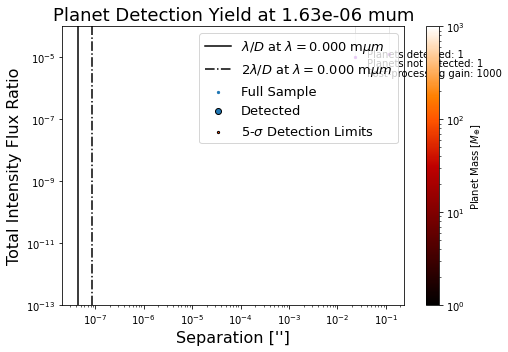

In [10]:
#Choose which wavelength you want to plot the detections at:
wv_index = 0
gpi.current_wvs = gpi.current_wvs[None]
detection_limits = detection_limits[:,None]
fig, ax = plots.plot_detected_planet_contrasts(planet_table[rand_planets],wv_index,
    detected,flux_ratios[:,None],gpi,gemini,ymin=1e-13,alt_data=5*detection_limits,alt_label=r"5-$\sigma$ Detection Limits", show=False)

#The user can now adjust the plot as they see fit. 
#e.g. Annotate the plot
ax.text(4e-2,1e-5,"Planets detected: {}".format(len(np.where(detected[:,wv_index])[0])),color='k')
ax.text(4e-2,0.5e-5,"Planets not detected: {}".format(len(np.where(~detected[:,wv_index])[0])),color='k')
ax.text(4e-2,0.25e-5,"Post-processing gain: {}".format(post_processing_gain),color='k')

In [11]:
planet_table[rand_planets][0][1]

137.21334838867188

In [13]:
planet_table

StarName,RA,Dec,Distance,Flux Ratio,AngSep,ProjAU,Phase,SMA,Ecc,Inc,PlanetMass,PlanetRadius,PlanetLogg,StarSpT,StarMass,StarTeff,StarRad,StarLogg,StarBMag,StarVmag,StarRmag,StarImag,StarJmag,StarHmag,StarKmag,StarAOmag
,,,,,mas,AU,rad,AU,,deg,earthMass,earthRad,dex(cm / s2),,solMass,K,solRad,dex(cm / s2),,,,,,,,
str12,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str14,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
HIP 263,0.8292379975318909,4.687136173248291,29.21,4.033515779747765e-10,16.645490312265874,0.48921555915454373,1.4599797566685684,0.4464116852882999,0.18832871742669402,134.37838258584915,0.7256250312965433,0.7984079757387531,3.0474176043573253,M1,0.5484326126868583,3839.195017835037,0.24093905210837854,5.413376504767409,13.51,12.04,0.0,0.0,8.833,8.183,7.9799999999999995,0.0
HIP 263,0.8292379975318909,4.687136173248291,29.21,2.687888451144109e-10,69.08797765275247,2.01836205965442,1.588102115735921,2.357992710746616,0.1458496979181811,83.55083070688147,11.332461805069995,1.6204958536969138,3.6261834976351204,M1,0.5484326126868583,3839.195017835037,0.24093905210837854,5.413376504767409,13.51,12.04,0.0,0.0,8.833,8.183,7.9799999999999995,0.0
HIP 400,1.2336599826812744,23.2696475982666,26.39,6.653354674100825e-09,39.20145376498934,1.118345481568613,1.9604233833416393,1.0011492520528018,0.12190702160654489,140.40701846624322,168.2336022988098,10.17465496875907,3.2020284446086,G9V,0.9538688335928661,5372.794136511371,0.7796415502055799,4.6337663336299855,8.58,7.81,0.0,0.0,6.398,6.027,5.93,0.0
HIP 400,1.2336599826812744,23.2696475982666,26.39,1.409970776385394e-09,17.641008028672243,0.9855802036552924,2.6496290850356203,0.9663643046024399,0.13693255373085272,111.54547571545247,3594.0,16.175515164285425,4.1290169124425296,G9V,0.9538688335928661,5372.794136511371,0.7796415502055799,4.6337663336299855,8.58,7.81,0.0,0.0,6.398,6.027,5.93,0.0
HIP 400,1.2336599826812744,23.2696475982666,26.39,4.414988432154103e-09,5.05706514612448,0.17702287469018482,2.2876281739144333,0.19558917276749915,0.09535270468385447,75.05081432964279,5.9505061940330854,2.3443223503464985,3.0256743374407433,G9V,0.9538688335928661,5372.794136511371,0.7796415502055799,4.6337663336299855,8.58,7.81,0.0,0.0,6.398,6.027,5.93,0.0
HIP 428,1.2923359870910645,45.78693389892578,11.25,4.733676871039638e-09,19.440230298505256,0.2243382153039655,1.7954159887525687,0.23507642351894464,0.33366866125189387,78.8006309819076,2.2200696753043423,1.6406227719095565,2.907504216084998,M2,0.5639554104203458,3839.195017835037,0.24295629879403066,5.418256069005674,11.42,9.95,0.0,0.0,6.704,6.098,5.85,0.0
HIP 428,1.2923359870910645,45.78693389892578,11.25,3.2368419828217466e-09,36.93914686488364,0.41565419691214156,1.5501258676696996,0.3699801630531343,0.35302152687540944,124.94391098602689,4.289825409901461,2.306616196968927,2.897644024703133,M2,0.5639554104203458,3839.195017835037,0.24295629879403066,5.418256069005674,11.42,9.95,0.0,0.0,6.704,6.098,5.85,0.0
HIP 428,1.2923359870910645,45.78693389892578,11.25,2.1222779489513625e-10,80.4038189526047,0.9695062261084295,1.9389498935990481,1.1665096749731163,0.2505385822964598,149.0707521584252,1.3278644933343218,1.264260978564397,2.910635372847907,M2,0.5639554104203458,3839.195017835037,0.24295629879403066,5.418256069005674,11.42,9.95,0.0,0.0,6.704,6.098,5.85,0.0


In [17]:
import math
math.log10(10)

1.0

In [5]:
wvs

<Quantity 1.63226e-06 m>